This is the 3rd Finetuned BERT Model For fake news detection with retuers and washington like keywords cleaning in preprocessing stages and take 25 features as an embeddings with the finetuned BERT embeddings with the 99.86% Accuracy.

🔴 CELL 1: Install Dependencies (⏱️ ~2 minutes)


In [ ]:
# ============================================================================
# CELL 1: INSTALL REQUIRED PACKAGES
# ============================================================================
print("Installing dependencies... This will take ~2 minutes")

!pip install -q transformers datasets torch pandas numpy scikit-learn textstat textblob vaderSentiment

print("✅ Installation complete!")

Installing dependencies... This will take ~2 minutes
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.3 MB/s eta 0:00:00
✅ Installation complete!


🟢 CELL 2: Import Libraries


In [ ]:
# ============================================================================
# CELL 2: IMPORT LIBRARIES
# ============================================================================
print("Importing libraries...")

import pandas as pd
import numpy as np
import re
import string
import torch
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Feature extraction libraries
import textstat
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

if device.type == 'cpu':
    print("⚠️ WARNING: GPU not detected! Training will be VERY slow.")
    print("   Go to: Runtime → Change runtime type → GPU")
else:
    print("✅ GPU detected! Training will be fast.")

Importing libraries...
✅ Using device: cuda
✅ GPU detected! Training will be fast.


🟠 CELL 3: Upload Dataset Files


In [ ]:
# ============================================================================
# CELL 3: UPLOAD DATASET
# ============================================================================
print("Please upload Fake.csv and True.csv")
print("Click the folder icon on the left, then click upload button")
print("\nWaiting for files...")

from google.colab import files
import time

# Check if files exist
import os
if not os.path.exists('Fake.csv') or not os.path.exists('True.csv'):
    print("\n📤 Upload your files now...")
    uploaded = files.upload()
    print("✅ Files uploaded!")
else:
    print("✅ Files already present!")

# Verify files
if os.path.exists('Fake.csv') and os.path.exists('True.csv'):
    print("\n✅ Both files found!")
    print(f"   Fake.csv size: {os.path.getsize('Fake.csv')/1024/1024:.2f} MB")
    print(f"   True.csv size: {os.path.getsize('True.csv')/1024/1024:.2f} MB")
else:
    print("❌ ERROR: Files not found!")
    print("   Please upload Fake.csv and True.csv")

Please upload Fake.csv and True.csv
Click the folder icon on the left, then click upload button

Waiting for files...

📤 Upload your files now...


✅ Files uploaded!
❌ ERROR: Files not found!
   Please upload Fake.csv and True.csv


🔵 CELL 4: Load and Explore Dataset


In [ ]:
# ============================================================================
# CELL 4: LOAD DATASET (FROM GOOGLE DRIVE)
# ============================================================================
print("="*70)
print("LOADING DATASET FROM GOOGLE DRIVE")
print("="*70)

from google.colab import drive
drive.mount('/content/drive')

# 🔴 CHANGE THIS PATH ONLY (folder where CSVs are stored)
DATASET_PATH = '/content/drive/MyDrive/News/'

# Load datasets
fake_df = pd.read_csv(DATASET_PATH + 'Fake.csv')
real_df = pd.read_csv(DATASET_PATH + 'True.csv')

print(f"\nFake news dataset shape: {fake_df.shape}")
print(f"Real news dataset shape: {real_df.shape}")

# Add labels
fake_df['label'] = 0  # Fake = 0
real_df['label'] = 1  # Real = 1

# Combine and shuffle
df = pd.concat([fake_df, real_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Keep only required columns
df = df[['text', 'label']]

print(f"\n✅ Combined dataset shape: {df.shape}")
print(f"✅ Fake news: {len(df[df['label']==0])} ({len(df[df['label']==0])/len(df)*100:.1f}%)")
print(f"✅ Real news: {len(df[df['label']==1])} ({len(df[df['label']==1])/len(df)*100:.1f}%)")

# Preview
print("\n📊 Sample data:")
print(df.head(3))


LOADING DATASET FROM GOOGLE DRIVE
Mounted at /content/drive

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)

✅ Combined dataset shape: (44898, 2)
✅ Fake news: 23481 (52.3%)
✅ Real news: 21417 (47.7%)

📊 Sample data:
                                                text  label
0  21st Century Wire says Ben Stein, reputable pr...      0
1  WASHINGTON (Reuters) - U.S. President Donald T...      1
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...      1


🟣 CELL 5: Define Feature Extraction Classes


In [ ]:
# ============================================================================
# CELL 5: DEFINE FEATURE EXTRACTION CLASSES
# ============================================================================
print("Defining feature extraction classes...")

class PreProcessingFeatureExtractor:
    """Extract features BEFORE text cleaning"""

    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

    def extract_all_features(self, text):
        text = str(text)
        if len(text) == 0:
            return {
                'original_length': 0,
                'caps_ratio': 0,
                'punctuation_ratio': 0,
                'special_char_ratio': 0,
                'digit_ratio': 0,
                'exclamation_ratio': 0,
                'question_ratio': 0,
            }

        uppercase_count = sum(1 for c in text if c.isupper())
        punct_count = sum(1 for c in text if c in string.punctuation)
        special_count = sum(1 for c in text if c in '!@#$%^&*')
        digit_count = sum(1 for c in text if c.isdigit())

        features = {
            'original_length': len(text),
            'caps_ratio': uppercase_count / len(text),
            'punctuation_ratio': punct_count / len(text),
            'special_char_ratio': special_count / len(text),
            'digit_ratio': digit_count / len(text),
            'exclamation_ratio': text.count('!') / len(text),
            'question_ratio': text.count('?') / len(text),
        }
        return features


class TextPreprocessor:
    """Clean and preprocess text"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        text = str(text)

        # ================================================================
        # REMOVE DATELINE / SOURCE LEAKAGE (START ONLY)
        # ================================================================

        # Pattern 1: "CITY (SOURCE) - "
        text = re.sub(
            r'^[A-Z][A-Z\s,]+\([A-Za-z\s]+\)\s*[-–—]\s*',
            '',
            text
        )

        # Pattern 2: "CITY - "
        text = re.sub(
            r'^[A-Z][A-Z\s]+\s*[-–—]\s*',
            '',
            text
        )

        # Pattern 3: "By Name - "
        text = re.sub(
            r'^By\s+[A-Z][\w\s]+[-,]\s*',
            '',
            text,
            flags=re.IGNORECASE
        )

        # ================================================================
        # STANDARD CLEANING
        # ================================================================
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = ' '.join(text.split())

        return text

    def preprocess(self, text, remove_stopwords=False):
        text = self.clean_text(text)
        text = text.lower()
        tokens = word_tokenize(text)

        if remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return ' '.join(tokens)


class PostProcessingFeatureExtractor:
    """Extract features AFTER text cleaning"""

    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

    def extract_all_features(self, text):
        text = str(text)
        words = text.split()
        sentences = sent_tokenize(text)

        features = {
            'word_count': len(words),
            'char_count': len(text),
            'sentence_count': len(sentences),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
            'avg_sentence_length': len(words) / len(sentences) if sentences else 0,
        }

        features['vocabulary_richness'] = len(set(words)) / len(words) if words else 0

        try:
            features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
            features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
            features['gunning_fog'] = textstat.gunning_fog(text)
            features['smog_index'] = textstat.smog_index(text)
            features['automated_readability_index'] = textstat.automated_readability_index(text)
            features['coleman_liau_index'] = textstat.coleman_liau_index(text)
        except:
            features.update({
                'flesch_reading_ease': 0,
                'flesch_kincaid_grade': 0,
                'gunning_fog': 0,
                'smog_index': 0,
                'automated_readability_index': 0,
                'coleman_liau_index': 0,
            })

        blob = TextBlob(text)
        vader_scores = self.vader.polarity_scores(text)

        features['polarity'] = blob.sentiment.polarity
        features['subjectivity'] = blob.sentiment.subjectivity
        features['vader_positive'] = vader_scores['pos']
        features['vader_negative'] = vader_scores['neg']
        features['vader_neutral'] = vader_scores['neu']
        features['vader_compound'] = vader_scores['compound']

        return features

print("✅ Feature extraction classes defined!")


Defining feature extraction classes...
✅ Feature extraction classes defined!


🟡 CELL 6: Extract Pre-Processing Features (⏱️ ~2-3 minutes)


In [ ]:
# ============================================================================
# CELL 6: EXTRACT PRE-PROCESSING FEATURES
# ============================================================================
print("="*70)
print("EXTRACTING PRE-PROCESSING FEATURES (Before cleaning)")
print("="*70)

pre_extractor = PreProcessingFeatureExtractor()

pre_features_list = []
total = len(df)

for idx, text in enumerate(df['text']):
    if idx % 5000 == 0:
        print(f"  Progress: {idx}/{total} ({idx/total*100:.1f}%)")

    features = pre_extractor.extract_all_features(text)
    pre_features_list.append(features)

pre_features_df = pd.DataFrame(pre_features_list)

print(f"\n✅ Pre-processing features extracted!")
print(f"   Shape: {pre_features_df.shape}")
print(f"   Features: {list(pre_features_df.columns)}")
print("\n📊 Sample features:")
print(pre_features_df.head())

EXTRACTING PRE-PROCESSING FEATURES (Before cleaning)
  Progress: 0/44898 (0.0%)
  Progress: 5000/44898 (11.1%)
  Progress: 10000/44898 (22.3%)
  Progress: 15000/44898 (33.4%)
  Progress: 20000/44898 (44.5%)
  Progress: 25000/44898 (55.7%)
  Progress: 30000/44898 (66.8%)
  Progress: 35000/44898 (78.0%)
  Progress: 40000/44898 (89.1%)

✅ Pre-processing features extracted!
   Shape: (44898, 7)
   Features: ['original_length', 'caps_ratio', 'punctuation_ratio', 'special_char_ratio', 'digit_ratio', 'exclamation_ratio', 'question_ratio']

📊 Sample features:
   original_length  caps_ratio  punctuation_ratio  special_char_ratio  \
0             1028    0.101167           0.012646            0.001946   
1             4820    0.045228           0.020747            0.000000   
2             1848    0.031385           0.024892            0.000000   
3             1244    0.044212           0.024920            0.000804   
4             3137    0.039847           0.021358            0.000319   

   

🟢 CELL 7: Preprocess Text (⏱️ ~3-4 minutes)


In [ ]:
# ============================================================================
# CELL 7: PREPROCESS TEXT (FIXED)
# ============================================================================
print("="*70)
print("PREPROCESSING TEXT")
print("="*70)

import nltk

# 🔒 Hard fix for NLTK resource issue
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

preprocessor = TextPreprocessor()

cleaned_texts = []
total = len(df)

for idx, text in enumerate(df['text']):
    if idx % 5000 == 0:
        print(f"  Progress: {idx}/{total} ({idx/total*100:.1f}%)")

    try:
        cleaned = preprocessor.preprocess(text)
    except LookupError:
        nltk.download('punkt')
        nltk.download('punkt_tab')
        cleaned = preprocessor.preprocess(text)

    cleaned_texts.append(cleaned)

df['cleaned_text'] = cleaned_texts

print("\n✅ Text preprocessing complete!")
print("\n📊 Example:")
print(f"Original: {df['text'].iloc[0][:200]}...")
print(f"\nCleaned: {df['cleaned_text'].iloc[0][:200]}...")


PREPROCESSING TEXT
  Progress: 0/44898 (0.0%)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Progress: 5000/44898 (11.1%)
  Progress: 10000/44898 (22.3%)
  Progress: 15000/44898 (33.4%)
  Progress: 20000/44898 (44.5%)
  Progress: 25000/44898 (55.7%)
  Progress: 30000/44898 (66.8%)
  Progress: 35000/44898 (78.0%)
  Progress: 40000/44898 (89.1%)

✅ Text preprocessing complete!

📊 Example:
Original: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative s...

Cleaned: 21st century wire say ben stein , reputable professor from , pepperdine university ( also of some hollywood fame appearing in tv show and film such a ferris bueller s day off ) made some provocative s...


CELL 7.5 - Add Verification

In [ ]:
# ============================================================================
# CELL 7.5 (NEW): VERIFY PREPROCESSING - CHECK FOR BIAS
# ============================================================================
print("="*70)
print("VERIFICATION: Checking for source leakage")
print("="*70)

# Check if suspicious patterns remain
def check_leakage(df, sample_size=10):
    """Check if datelines were properly removed"""

    print("\n📊 Checking random samples:\n")

    indices = np.random.choice(len(df), sample_size, replace=False)

    for i, idx in enumerate(indices[:5], 1):  # Show 5 examples
        original = df['text'].iloc[idx]
        cleaned = df['cleaned_text'].iloc[idx]
        label = 'REAL' if df['label'].iloc[idx] == 1 else 'FAKE'

        print(f"Example {i} ({label}):")
        print(f"Original start: {original[:80]}...")
        print(f"Cleaned start:  {cleaned[:80]}...")
        print("-"*70)

    # Check for remaining dateline patterns
    dateline_pattern = r'^[A-Z][A-Z\s]+([-–—]|\()'
    remaining = df['cleaned_text'].str.match(dateline_pattern, na=False).sum()

    print(f"\n📈 Statistics:")
    print(f"   Texts with dateline pattern remaining: {remaining} ({remaining/len(df)*100:.2f}%)")

    if remaining < len(df) * 0.01:  # Less than 1%
        print("   ✅ Preprocessing looks good!")
    else:
        print("   ⚠️  Warning: Many datelines still present")

    # Check specific terms (in lowercase cleaned text)
    terms_to_check = ['reuters', 'washington', 'new york', 'london']
    print(f"\n📝 Word frequency check (in body text is OK):")
    for term in terms_to_check:
        # Count occurrences in cleaned text
        count = df['cleaned_text'].str.contains(term, case=False, na=False).sum()
        pct = (count / len(df)) * 100
        print(f"   '{term}': {count} articles ({pct:.1f}%)")

check_leakage(df, sample_size=10)

VERIFICATION: Checking for source leakage

📊 Checking random samples:

Example 1 (FAKE):
Original start: James Kallstrom is the former Assistant Director of the FBI who is no fan of for...
Cleaned start:  james kallstrom is the former assistant director of the fbi who is no fan of for...
----------------------------------------------------------------------
Example 2 (FAKE):
Original start: Indoctrination by Disney pretty much covers every demographic: toddlers with sip...
Cleaned start:  indoctrination by disney pretty much cover every demographic : toddler with sipp...
----------------------------------------------------------------------
Example 3 (REAL):
Original start: WASHINGTON (Reuters) - When Donald Trump faced criticism from advocacy groups fo...
Cleaned start:  when donald trump faced criticism from advocacy group for not including more wom...
----------------------------------------------------------------------
Example 4 (FAKE):
Original start: THIS IS MADDENING! We have a

🔵 CELL 8: Extract Post-Processing Features (⏱️ ~5-6 minutes)


In [ ]:
# ============================================================================
# CELL 8: EXTRACT POST-PROCESSING FEATURES
# ============================================================================
print("="*70)
print("EXTRACTING POST-PROCESSING FEATURES (After cleaning)")
print("="*70)

post_extractor = PostProcessingFeatureExtractor()

post_features_list = []
total = len(df)

for idx, text in enumerate(df['cleaned_text']):
    if idx % 5000 == 0:
        print(f"  Progress: {idx}/{total} ({idx/total*100:.1f}%)")

    features = post_extractor.extract_all_features(text)
    post_features_list.append(features)

post_features_df = pd.DataFrame(post_features_list)

print(f"\n✅ Post-processing features extracted!")
print(f"   Shape: {post_features_df.shape}")
print(f"   Features: {list(post_features_df.columns)}")
print("\n📊 Sample features:")
print(post_features_df.head())

EXTRACTING POST-PROCESSING FEATURES (After cleaning)
  Progress: 0/44898 (0.0%)
  Progress: 5000/44898 (11.1%)
  Progress: 10000/44898 (22.3%)
  Progress: 15000/44898 (33.4%)
  Progress: 20000/44898 (44.5%)
  Progress: 25000/44898 (55.7%)
  Progress: 30000/44898 (66.8%)
  Progress: 35000/44898 (78.0%)
  Progress: 40000/44898 (89.1%)

✅ Post-processing features extracted!
   Shape: (44898, 18)
   Features: ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'vocabulary_richness', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'automated_readability_index', 'coleman_liau_index', 'polarity', 'subjectivity', 'vader_positive', 'vader_negative', 'vader_neutral', 'vader_compound']

📊 Sample features:
   word_count  char_count  sentence_count  avg_word_length  \
0         181        1019               5         4.635359   
1         895        4859              29         4.430168   
2         348        1845              14    

🟣 CELL 9: Combine and Normalize Features


In [ ]:
# ============================================================================
# CELL 9: COMBINE AND NORMALIZE ALL FEATURES
# ============================================================================
print("="*70)
print("COMBINING AND NORMALIZING FEATURES")
print("="*70)

# Combine all features
all_numerical_features = pd.concat([pre_features_df, post_features_df], axis=1)

print(f"\n📊 Total features: {all_numerical_features.shape[1]}")
print(f"   Feature list: {list(all_numerical_features.columns)}")

# Handle invalid values
all_numerical_features = all_numerical_features.replace([np.inf, -np.inf], np.nan)
all_numerical_features = all_numerical_features.fillna(0)

# Normalize features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(all_numerical_features)
numerical_features_scaled = pd.DataFrame(
    numerical_features_scaled,
    columns=all_numerical_features.columns
)

print(f"\n✅ Features combined and normalized!")
print("\n📊 Feature statistics:")
print(numerical_features_scaled.describe())

COMBINING AND NORMALIZING FEATURES

📊 Total features: 25
   Feature list: ['original_length', 'caps_ratio', 'punctuation_ratio', 'special_char_ratio', 'digit_ratio', 'exclamation_ratio', 'question_ratio', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'vocabulary_richness', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'automated_readability_index', 'coleman_liau_index', 'polarity', 'subjectivity', 'vader_positive', 'vader_negative', 'vader_neutral', 'vader_compound']

✅ Features combined and normalized!

📊 Feature statistics:
       original_length    caps_ratio  punctuation_ratio  special_char_ratio  \
count     4.489800e+04  4.489800e+04       4.489800e+04        4.489800e+04   
mean     -1.097909e-17 -1.212249e-16      -1.449635e-16       -2.120645e-17   
std       1.000011e+00  1.000011e+00       1.000011e+00        1.000011e+00   
min      -1.136543e+00 -1.255196e+00      -1.934670e+00       -2.894921e-01   
2

🟠 CELL 10: Split Dataset


In [ ]:
# ============================================================================
# CELL 10: SPLIT DATASET
# ============================================================================
print("="*70)
print("SPLITTING DATASET")
print("="*70)

# Split into train, validation, test
train_texts, test_texts, train_labels, test_labels, train_numerical, test_numerical = train_test_split(
    df['cleaned_text'].values,
    df['label'].values,
    numerical_features_scaled.values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

train_texts, val_texts, train_labels, val_labels, train_numerical, val_numerical = train_test_split(
    train_texts, train_labels, train_numerical,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)

print(f"✅ Dataset split complete!")
print(f"   Train: {len(train_texts)} samples")
print(f"   Validation: {len(val_texts)} samples")
print(f"   Test: {len(test_texts)} samples")
print(f"\n   Train - Fake: {sum(train_labels==0)}, Real: {sum(train_labels==1)}")
print(f"   Val   - Fake: {sum(val_labels==0)}, Real: {sum(val_labels==1)}")
print(f"   Test  - Fake: {sum(test_labels==0)}, Real: {sum(test_labels==1)}")

SPLITTING DATASET
✅ Dataset split complete!
   Train: 32326 samples
   Validation: 3592 samples
   Test: 8980 samples

   Train - Fake: 16906, Real: 15420
   Val   - Fake: 1879, Real: 1713
   Test  - Fake: 4696, Real: 4284


🔴 CELL 11: Create PyTorch Dataset


In [ ]:
# ============================================================================
# CELL 11: CREATE PYTORCH DATASETS
# ============================================================================
print("="*70)
print("CREATING PYTORCH DATASETS")
print("="*70)

MODEL_NAME = 'bert-base-uncased'
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class HybridNewsDataset(Dataset):
    """Custom Dataset combining text and numerical features"""

    def __init__(self, texts, labels, numerical_features, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.numerical_features = numerical_features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numerical_features': torch.tensor(self.numerical_features[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = HybridNewsDataset(train_texts, train_labels, train_numerical, tokenizer)
val_dataset = HybridNewsDataset(val_texts, val_labels, val_numerical, tokenizer)
test_dataset = HybridNewsDataset(test_texts, test_labels, test_numerical, tokenizer)

print(f"\n✅ PyTorch datasets created!")
print(f"   Train dataset: {len(train_dataset)} samples")
print(f"   Val dataset: {len(val_dataset)} samples")
print(f"   Test dataset: {len(test_dataset)} samples")

CREATING PYTORCH DATASETS
Loading tokenizer: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


✅ PyTorch datasets created!
   Train dataset: 32326 samples
   Val dataset: 3592 samples
   Test dataset: 8980 samples


🟢 CELL 12: Create Hybrid BERT Model


In [ ]:
# ============================================================================
# CELL 12: CREATE HYBRID BERT MODEL
# ============================================================================
print("="*70)
print("CREATING HYBRID BERT MODEL")
print("="*70)

class HybridBertForClassification(torch.nn.Module):
    """
    Hybrid model combining:
    - BERT embeddings (768 dims)
    - Numerical features (25+ dims)
    """

    def __init__(self, num_numerical_features, num_labels=2, dropout=0.3):
        super(HybridBertForClassification, self).__init__()

        # Load BERT
        self.bert = BertForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=num_labels,
            output_attentions=False,
            output_hidden_states=True
        )

        self.bert_hidden_size = self.bert.config.hidden_size  # 768

        # Feature fusion layer
        self.feature_combiner = torch.nn.Linear(
            self.bert_hidden_size + num_numerical_features,
            256
        )

        # Classification layers
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(256, num_labels)
        self.layer_norm = torch.nn.LayerNorm(256)

    def forward(self, input_ids, attention_mask, numerical_features, labels=None):
        # Get BERT embeddings
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        # Combine BERT + numerical features
        combined_features = torch.cat([cls_output, numerical_features], dim=1)

        # Pass through fusion layer
        fused = self.feature_combiner(combined_features)
        fused = torch.nn.functional.relu(fused)
        fused = self.layer_norm(fused)
        fused = self.dropout(fused)

        # Classification
        logits = self.classifier(fused)

        # Calculate loss
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits}

# Create model
num_numerical_features = numerical_features_scaled.shape[1]
model = HybridBertForClassification(num_numerical_features=num_numerical_features)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   BERT hidden size: 768")
print(f"   Numerical features: {num_numerical_features}")
print(f"   Combined size: {768 + num_numerical_features}")

CREATING HYBRID BERT MODEL


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model created!
   Total parameters: 109,688,068
   Trainable parameters: 109,688,068
   BERT hidden size: 768
   Numerical features: 25
   Combined size: 793


🔵 CELL 13: Configure Training


In [ ]:
# ============================================================================
# CELL 13: CONFIGURE TRAINING (FIXED FOR YOUR VERSION)
# ============================================================================
print("="*70)
print("CONFIGURING TRAINING")
print("="*70)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,              # ✅ Epoch = 2
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='steps',           # ✅ CORRECT KEY FOR YOUR VERSION
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

class HybridTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            numerical_features=inputs["numerical_features"],
            labels=labels
        )
        return (outputs["loss"], outputs) if return_outputs else outputs["loss"]


trainer = HybridTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("✅ Training configured!")
print("   Epochs: 2")
print("   Batch size: 16")
print(f"   Mixed precision: {torch.cuda.is_available()}")
print("   Early stopping: Yes (patience=3)")


CONFIGURING TRAINING
✅ Training configured!
   Epochs: 2
   Batch size: 16
   Mixed precision: True
   Early stopping: Yes (patience=3)


🟣 CELL 14: Train Model (⏱️ ~30-45 minutes)


In [ ]:
# ============================================================================
# CELL 14: TRAIN MODEL
# ============================================================================
print("="*70)
print("STARTING TRAINING")
print("="*70)
print("⏱️ This will take approximately 30-45 minutes...")
print("☕ Good time for a coffee break!\n")

# Train
trainer.train()

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

STARTING TRAINING
⏱️ This will take approximately 30-45 minutes...
☕ Good time for a coffee break!



wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss,Validation Loss,Accuracy
500,0.042900,0.094117,0.981347
1000,0.030500,0.012041,0.996938
1500,0.013900,0.019808,0.996381
2000,0.021900,0.014274,0.997494
2500,0.006600,0.009494,0.998330
3000,0.002000,0.017672,0.997216
3500,0.009400,0.010270,0.998608
4000,0.004200,0.011590,0.997773



✅ TRAINING COMPLETE!


🟠 CELL 15: Evaluate Model


In [ ]:
# ============================================================================
# CELL 15: EVALUATE ON TEST SET
# ============================================================================
print("="*70)
print("EVALUATING MODEL")
print("="*70)

# Predict on test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(test_labels, pred_labels)

print("\n" + "="*70)
print("📊 TEST SET RESULTS")
print("="*70)
print(f"\n🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n📋 Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=['Fake', 'Real']))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print(f"\nTrue Negatives (Fake correctly identified): {cm[0][0]}")
print(f"False Positives (Fake misclassified as Real): {cm[0][1]}")
print(f"False Negatives (Real misclassified as Fake): {cm[1][0]}")
print(f"True Positives (Real correctly identified): {cm[1][1]}")

EVALUATING MODEL



📊 TEST SET RESULTS

🎯 Accuracy: 0.9986 (99.86%)

📋 Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


📊 Confusion Matrix:
[[4687    9]
 [   4 4280]]

True Negatives (Fake correctly identified): 4687
False Positives (Fake misclassified as Real): 9
False Negatives (Real misclassified as Fake): 4
True Positives (Real correctly identified): 4280


🔴 CELL 16: Save Model


In [ ]:
# ============================================================================
# CELL 16: SAVE & UPDATE MODEL ON HUGGING FACE (SIMPLE)
# ============================================================================
print("="*70)
print("SAVING MODEL TO HUGGING FACE")
print("="*70)

import os
import torch
import joblib
from huggingface_hub import login, HfApi
from datetime import datetime

# Login
login()

# Settings
HF_USERNAME = "DarkKnight001"
REPO_NAME = "hybrid-bert-fake-news-claude"  # Same name = will replace
HF_REPO_ID = f"{HF_USERNAME}/{REPO_NAME}"
SAVE_DIR = "./hybrid_bert_fake_news_model"

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n📦 Repository: {HF_REPO_ID}")
print("   (Old files will be automatically replaced)\n")

# ------------------------------------------------------------------
# SAVE ALL FILES LOCALLY
# ------------------------------------------------------------------
print("💾 Saving files locally...")

# 1. Model weights
torch.save(model.state_dict(), f"{SAVE_DIR}/pytorch_model.bin")

# 2. Model config
model_config = {
    "model_type": "hybrid_bert",
    "bert_model": MODEL_NAME,
    "num_numerical_features": num_numerical_features,
    "num_labels": 2,
    "training_accuracy": float(accuracy),
    "trained_on": datetime.now().isoformat(),
    "debiased": True  # Flag indicating improved preprocessing
}
torch.save(model_config, f"{SAVE_DIR}/model_config.pt")

# 3. Tokenizer
tokenizer.save_pretrained(SAVE_DIR)

# 4. Feature extractors
joblib.dump(scaler, f"{SAVE_DIR}/feature_scaler.pkl")
joblib.dump(pre_extractor, f"{SAVE_DIR}/pre_extractor.pkl")
joblib.dump(post_extractor, f"{SAVE_DIR}/post_extractor.pkl")
joblib.dump(preprocessor, f"{SAVE_DIR}/preprocessor.pkl")

# 5. Create README
readme = f"""---
license: apache-2.0
tags:
- fake-news-detection
- bert
- hybrid-model
---

# Hybrid BERT Fake News Detection

## Model Description
Combines BERT-base-uncased with 25+ linguistic features.

### Performance
- **Accuracy**: {accuracy*100:.2f}%
- **Features**: {num_numerical_features} numerical + 768 BERT embeddings

### Preprocessing
Uses minimal debiasing - removes only dateline patterns at article start,
preserving all content words and citations.

### Updated
{datetime.now().strftime('%Y-%m-%d %H:%M')}
"""

with open(f"{SAVE_DIR}/README.md", 'w') as f:
    f.write(readme)

print("✅ Files saved locally")

# ------------------------------------------------------------------
# UPLOAD TO HUGGING FACE (Replaces old files automatically)
# ------------------------------------------------------------------
print(f"\n🚀 Uploading to {HF_REPO_ID}...")

api = HfApi()
api.create_repo(repo_id=HF_REPO_ID, exist_ok=True)

api.upload_folder(
    folder_path=SAVE_DIR,
    repo_id=HF_REPO_ID,
    repo_type="model",
    commit_message="Update model with improved preprocessing"
)

print("\n" + "="*70)
print("✅ MODEL SUCCESSFULLY UPDATED")
print("="*70)
print(f"\n🔗 https://huggingface.co/{HF_REPO_ID}")
print("\n📝 What happened:")
print("   • Old files automatically replaced")
print("   • New model with improved preprocessing uploaded")
print("   • README updated with new accuracy")

SAVING MODEL TO HUGGING FACE



📦 Repository: DarkKnight001/hybrid-bert-fake-news-claude
   (Old files will be automatically replaced)

💾 Saving files locally...
✅ Files saved locally

🚀 Uploading to DarkKnight001/hybrid-bert-fake-news-claude...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._model/post_extractor.pkl: 100%|##########|  843kB /  843kB            

  ...ws_model/preprocessor.pkl: 100%|##########| 1.57kB / 1.57kB            

  ..._model/feature_scaler.pkl: 100%|##########| 1.89kB / 1.89kB            

  ...s_model/pre_extractor.pkl: 100%|##########|  843kB /  843kB            

  ...s_model/pytorch_model.bin:   8%|7         | 33.5MB /  439MB            

  ...ews_model/model_config.pt: 100%|##########| 1.48kB / 1.48kB            


✅ MODEL SUCCESSFULLY UPDATED

🔗 https://huggingface.co/DarkKnight001/hybrid-bert-fake-news-claude

📝 What happened:
   • Old files automatically replaced
   • New model with improved preprocessing uploaded
   • README updated with new accuracy


🟢 CELL 17: Test Inference Function


In [ ]:
# ============================================================================
# CELL 17: TEST INFERENCE
# ============================================================================
print("="*70)
print("TESTING INFERENCE FUNCTION")
print("="*70)

def predict_news(text, model, tokenizer, scaler, pre_extractor, post_extractor, preprocessor):
    """Predict if news is fake or real"""

    model.eval()

    # 1️⃣ Pre-processing features (before cleaning)
    pre_features = pre_extractor.extract_all_features(text)

    # 2️⃣ Clean text
    cleaned = preprocessor.preprocess(text)

    # 3️⃣ Post-processing features (after cleaning)
    post_features = post_extractor.extract_all_features(cleaned)

    # 4️⃣ Combine numerical features
    all_features = {**pre_features, **post_features}
    feature_names = scaler.feature_names_in_
    feature_vector = np.array([[all_features[f] for f in feature_names]])
    feature_vector = scaler.transform(feature_vector)

    # 5️⃣ Tokenize text
    encoding = tokenizer(
        cleaned,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # 6️⃣ Move tensors to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    numerical_features = torch.tensor(feature_vector, dtype=torch.float).to(device)

    # 7️⃣ Prediction
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            numerical_features=numerical_features
        )

        logits = outputs['logits']
        probs = torch.nn.functional.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()

    return {
        'prediction': 'Real' if prediction == 1 else 'Fake',
        'confidence': round(confidence, 4),
        'probabilities': {
            'Fake': round(probs[0][0].item(), 4),
            'Real': round(probs[0][1].item(), 4)
        }
    }

# ------------------------------------------------------------------
# 🔍 TEST ON RANDOM SAMPLE FROM TEST SET
# ------------------------------------------------------------------
sample_idx = np.random.randint(0, len(test_texts))
sample_text = test_texts[sample_idx]
true_label = 'Real' if test_labels[sample_idx] == 1 else 'Fake'

result = predict_news(
    sample_text,
    model,
    tokenizer,
    scaler,
    pre_extractor,
    post_extractor,
    preprocessor
)

print("\n📰 SAMPLE NEWS ARTICLE:")
print(sample_text[:400] + "...\n")

print("🎯 TRUE LABEL:", true_label)
print("🤖 PREDICTED LABEL:", result['prediction'])
print("📊 CONFIDENCE:", result['confidence'])
print("📈 CLASS PROBABILITIES:")
print("   Fake:", result['probabilities']['Fake'])
print("   Real:", result['probabilities']['Real'])

print("\n" + "="*70)
print("✅ INFERENCE TEST COMPLETED SUCCESSFULLY")
print("="*70)


TESTING INFERENCE FUNCTION

📰 SAMPLE NEWS ARTICLE:
in light of the russian hacking scandal that interfered in our nation s election , it seemed to many that the obama administration wa taking it lying down . it wasn t , at least according to a ground breaking report by the new york time that say that in his final day , the president worked to create a trail leading directly from russia to donald trump.in the obama administration s last day , some ...

🎯 TRUE LABEL: Fake
🤖 PREDICTED LABEL: Fake
📊 CONFIDENCE: 0.9999
📈 CLASS PROBABILITIES:
   Fake: 0.9999
   Real: 0.0001

✅ INFERENCE TEST COMPLETED SUCCESSFULLY


🔵 CELL 18: Prepare Data for Visualization


In [ ]:
# ============================================================================
# CELL 18: PREPARE DATA FOR VISUALIZATION
# ============================================================================
print("="*70)
print("PREPARING DATA FOR VISUALIZATION")
print("="*70)

# Combine df with features for analysis
df_with_features = pd.concat([df, all_numerical_features], axis=1)

print(f"✅ Combined dataset shape: {df_with_features.shape}")
print(f"✅ Columns: {df_with_features.columns.tolist()}")

PREPARING DATA FOR VISUALIZATION
✅ Combined dataset shape: (44898, 28)
✅ Columns: ['text', 'label', 'cleaned_text', 'original_length', 'caps_ratio', 'punctuation_ratio', 'special_char_ratio', 'digit_ratio', 'exclamation_ratio', 'question_ratio', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'vocabulary_richness', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'automated_readability_index', 'coleman_liau_index', 'polarity', 'subjectivity', 'vader_positive', 'vader_negative', 'vader_neutral', 'vader_compound']


🟣 CELL 19: Dataset Statistics


In [ ]:
# ============================================================================
# CELL 19: DATASET STATISTICS
# ============================================================================
print("="*70)
print("DATASET-LEVEL STATISTICS")
print("="*70)

fake_count = len(df[df['label'] == 0])
real_count = len(df[df['label'] == 1])

print(f"\n1. CLASS DISTRIBUTION:")
print(f"   Total Articles: {len(df):,}")
print(f"   Fake News: {fake_count:,} ({fake_count/len(df)*100:.2f}%)")
print(f"   Real News: {real_count:,} ({real_count/len(df)*100:.2f}%)")
print(f"   Fake/Real Ratio: {fake_count/real_count:.2f}")

print(f"\n2. AVERAGE ARTICLE LENGTH BY CLASS:")
fake_words = df_with_features[df_with_features['label']==0]['word_count'].mean()
real_words = df_with_features[df_with_features['label']==1]['word_count'].mean()
print(f"   Fake News - Avg Words: {fake_words:.0f}")
print(f"   Real News - Avg Words: {real_words:.0f}")
print(f"   Difference: {abs(fake_words - real_words):.0f} words")

print(f"\n3. READABILITY SCORES:")
fake_flesch = df_with_features[df_with_features['label']==0]['flesch_reading_ease'].mean()
real_flesch = df_with_features[df_with_features['label']==1]['flesch_reading_ease'].mean()
print(f"   Fake News - Flesch Reading Ease: {fake_flesch:.2f}")
print(f"   Real News - Flesch Reading Ease: {real_flesch:.2f}")
print(f"   (Higher = easier to read)")

print(f"\n4. SENTIMENT PATTERNS:")
fake_subj = df_with_features[df_with_features['label']==0]['subjectivity'].mean()
real_subj = df_with_features[df_with_features['label']==1]['subjectivity'].mean()
print(f"   Fake News - Subjectivity: {fake_subj:.3f}")
print(f"   Real News - Subjectivity: {real_subj:.3f}")
print(f"   Fake is {((fake_subj/real_subj - 1)*100):.1f}% more subjective")

print(f"\n5. VOCABULARY RICHNESS:")
fake_ttr = df_with_features[df_with_features['label']==0]['vocabulary_richness'].mean()
real_ttr = df_with_features[df_with_features['label']==1]['vocabulary_richness'].mean()
print(f"   Fake News - TTR: {fake_ttr:.3f}")
print(f"   Real News - TTR: {real_ttr:.3f}")
print(f"   (Higher = more diverse vocabulary)")

DATASET-LEVEL STATISTICS

1. CLASS DISTRIBUTION:
   Total Articles: 44,898
   Fake News: 23,481 (52.30%)
   Real News: 21,417 (47.70%)
   Fake/Real Ratio: 1.10

2. AVERAGE ARTICLE LENGTH BY CLASS:
   Fake News - Avg Words: 465
   Real News - Avg Words: 431
   Difference: 35 words

3. READABILITY SCORES:
   Fake News - Flesch Reading Ease: 50.82
   Real News - Flesch Reading Ease: 43.14
   (Higher = easier to read)

4. SENTIMENT PATTERNS:
   Fake News - Subjectivity: 0.430
   Real News - Subjectivity: 0.361
   Fake is 19.2% more subjective

5. VOCABULARY RICHNESS:
   Fake News - TTR: 0.522
   Real News - TTR: 0.539
   (Higher = more diverse vocabulary)


🟠 CELL 20: Feature Importance Analysis


In [ ]:
# ============================================================================
# CELL 20: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("="*70)
print("FEATURE DISCRIMINATIVE POWER (T-TEST)")
print("="*70)

feature_cols = all_numerical_features.columns.tolist()
results = []

for feature in feature_cols:
    fake_values = df_with_features[df_with_features['label']==0][feature]
    real_values = df_with_features[df_with_features['label']==1][feature]

    # T-test
    t_stat, p_value = stats.ttest_ind(fake_values, real_values)

    # Effect size (Cohen's d)
    cohens_d = (fake_values.mean() - real_values.mean()) / np.sqrt(
        (fake_values.std()**2 + real_values.std()**2) / 2
    )

    results.append({
        'Feature': feature,
        'Fake_Mean': fake_values.mean(),
        'Real_Mean': real_values.mean(),
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Cohens_D': abs(cohens_d),
        'Significant': 'Yes' if p_value < 0.001 else 'No'
    })

feature_importance = pd.DataFrame(results)
feature_importance = feature_importance.sort_values('Cohens_D', ascending=False)

print("\n📊 Top 15 Most Discriminative Features:")
print(feature_importance.head(15)[['Feature', 'Fake_Mean', 'Real_Mean', 'Cohens_D', 'Significant']].to_string(index=False))

# Save to CSV
feature_importance.to_csv('feature_importance.csv', index=False)
print("\n✅ Saved: feature_importance.csv")

FEATURE DISCRIMINATIVE POWER (T-TEST)

📊 Top 15 Most Discriminative Features:
                    Feature  Fake_Mean  Real_Mean  Cohens_D Significant
                gunning_fog  13.097418  15.631127  0.780930         Yes
       flesch_kincaid_grade  10.683514  12.893763  0.768290         Yes
                 smog_index  12.625271  14.540885  0.758101         Yes
         coleman_liau_index   9.645623  11.297370  0.721796         Yes
        flesch_reading_ease  50.820407  43.140480  0.602083         Yes
automated_readability_index   9.245765  11.300278  0.597995         Yes
               subjectivity   0.430362   0.361078  0.549901         Yes
             question_ratio   0.000606   0.000031  0.476172         Yes
            avg_word_length   4.273953   4.533581  0.422965         Yes
              vader_neutral   0.796023   0.844308  0.418016         Yes
         special_char_ratio   0.001758   0.000314  0.406695         Yes
             vader_negative   0.083405   0.069927  0.27795

🔴 CELL 21: Visualization 1 - Class Distribution


Creating class distribution plot...


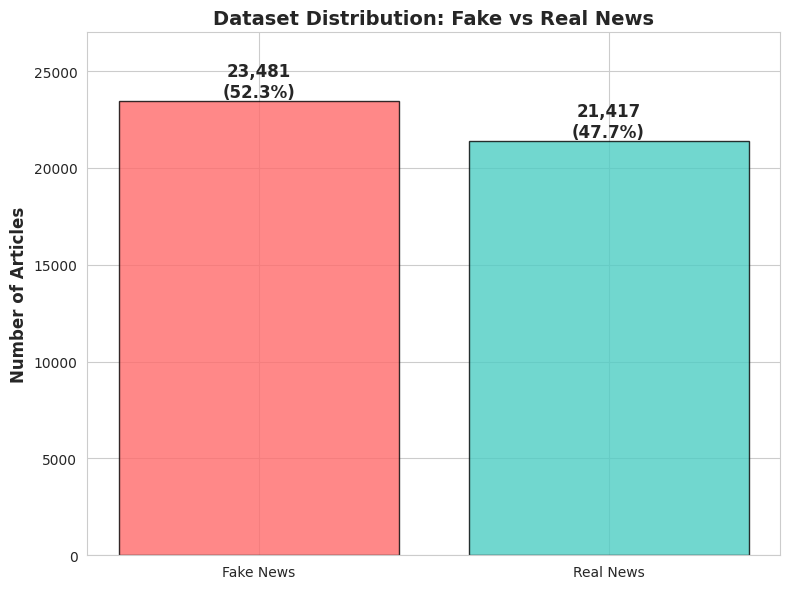

✅ Saved: 1_class_distribution.png


In [ ]:
# ============================================================================
# CELL 21: VISUALIZATION 1 - CLASS DISTRIBUTION
# ============================================================================
print("Creating class distribution plot...")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_counts = df['label'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(['Fake News', 'Real News'], class_counts.values, color=colors, alpha=0.8, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Articles', fontsize=12, fontweight='bold')
ax.set_title('Dataset Distribution: Fake vs Real News', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(class_counts.values) * 1.15)

plt.tight_layout()
plt.savefig('1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 1_class_distribution.png")

🟢 CELL 22: Visualization 2 - Feature Comparison


Creating feature comparison boxplots...


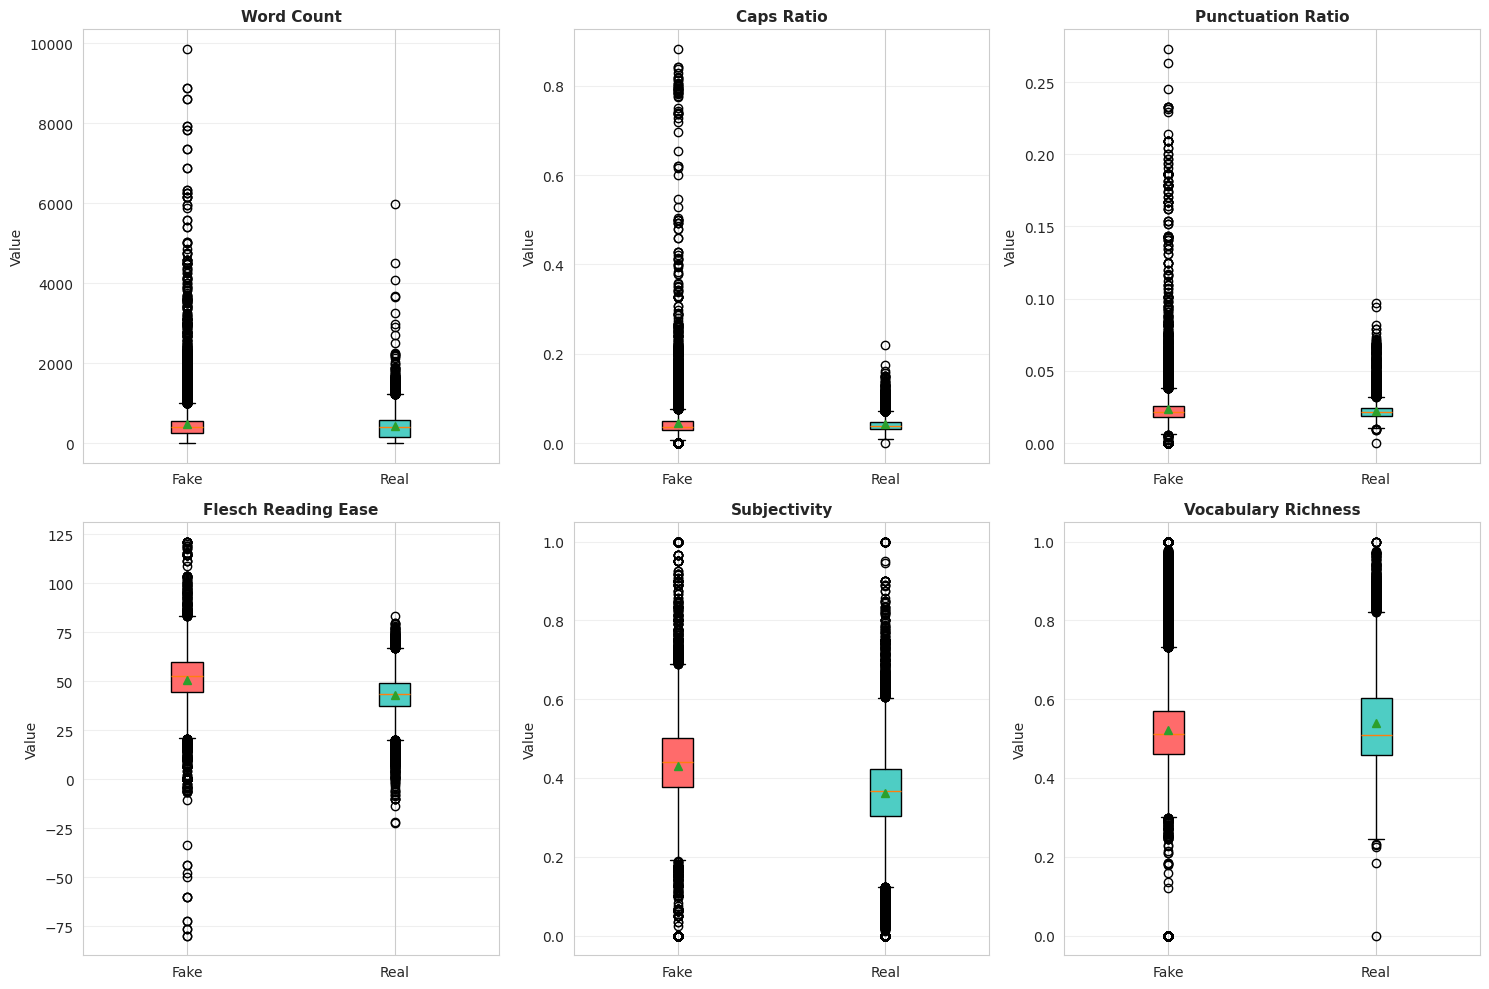

✅ Saved: 2_feature_comparison_boxplot.png


In [ ]:
# ============================================================================
# CELL 22: VISUALIZATION 2 - FEATURE COMPARISON BOXPLOTS
# ============================================================================
print("Creating feature comparison boxplots...")

features_to_plot = [
    'word_count', 'caps_ratio', 'punctuation_ratio',
    'flesch_reading_ease', 'subjectivity', 'vocabulary_richness'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]

    fake_data = df_with_features[df_with_features['label']==0][feature]
    real_data = df_with_features[df_with_features['label']==1][feature]

    bp = ax.boxplot([fake_data, real_data],
                    labels=['Fake', 'Real'],
                    patch_artist=True,
                    showmeans=True)

    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#4ECDC4')

    ax.set_title(feature.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('2_feature_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 2_feature_comparison_boxplot.png")

🔵 CELL 23: Visualization 3 - Feature Importance


Creating feature importance plot...


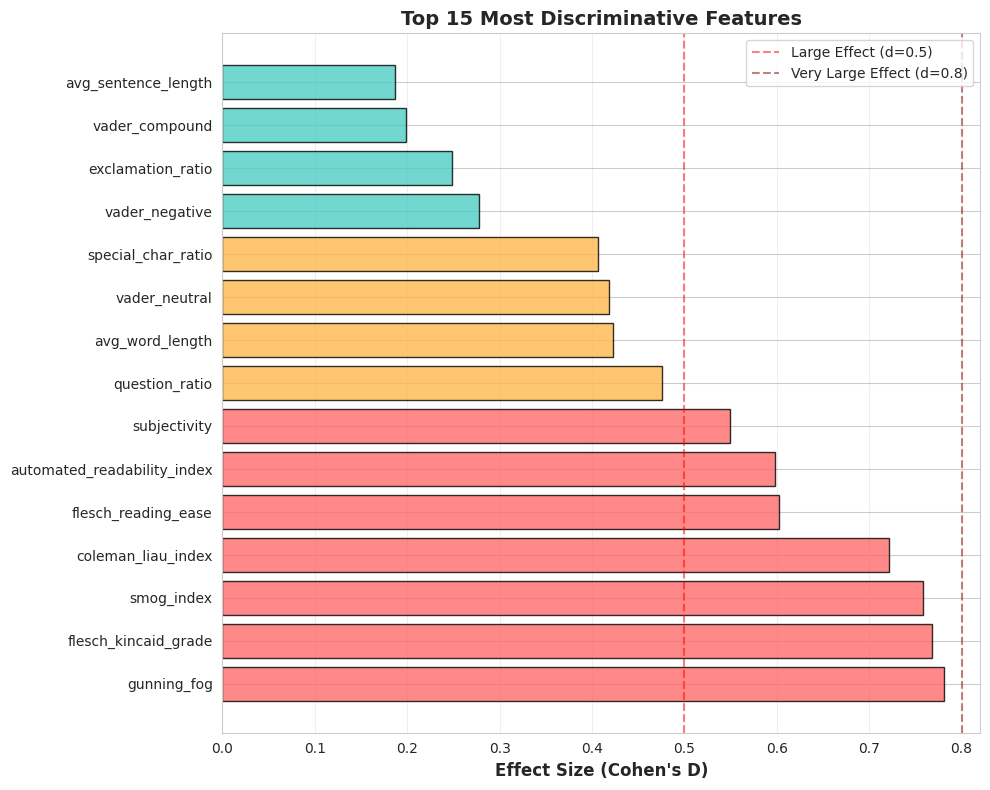

✅ Saved: 3_feature_importance.png


In [ ]:
# ============================================================================
# CELL 23: VISUALIZATION 3 - FEATURE IMPORTANCE
# ============================================================================
print("Creating feature importance plot...")

top_features = feature_importance.head(15).copy()

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B' if x > 0.5 else '#FFB84D' if x > 0.3 else '#4ECDC4'
          for x in top_features['Cohens_D']]

bars = ax.barh(top_features['Feature'], top_features['Cohens_D'], color=colors, alpha=0.8, edgecolor='black')

ax.set_xlabel("Effect Size (Cohen's D)", fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Discriminative Features', fontsize=14, fontweight='bold')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Large Effect (d=0.5)')
ax.axvline(x=0.8, color='darkred', linestyle='--', alpha=0.5, label='Very Large Effect (d=0.8)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('3_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 3_feature_importance.png")

🟣 CELL 24: Visualization 4 - Readability Comparison


Creating readability comparison plot...


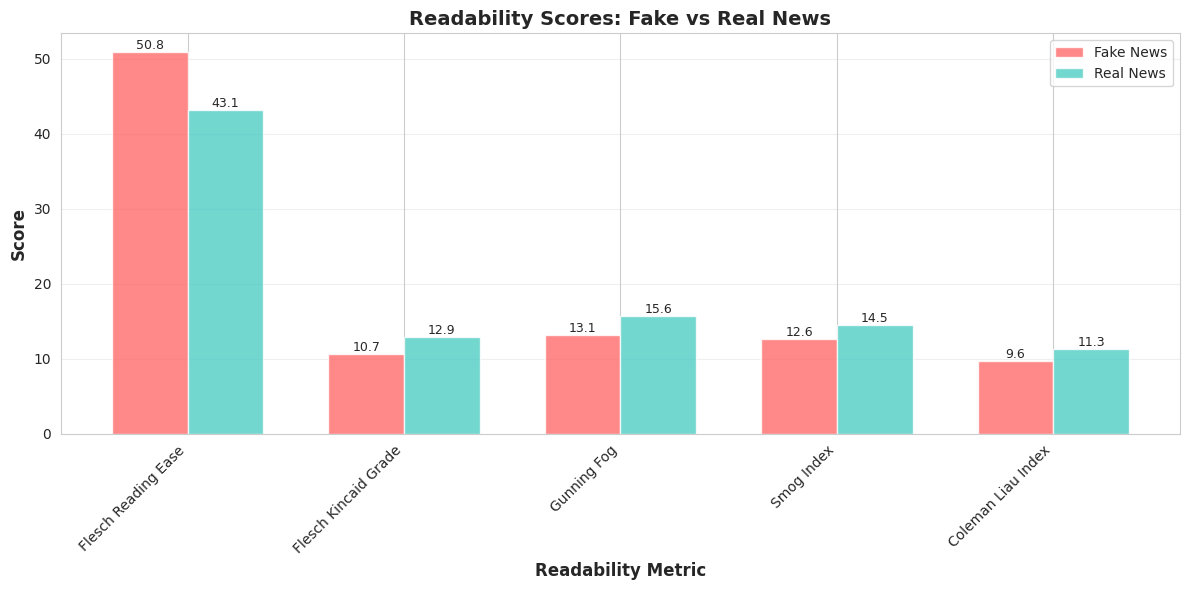

✅ Saved: 4_readability_comparison.png


In [ ]:
# ============================================================================
# CELL 24: VISUALIZATION 4 - READABILITY COMPARISON
# ============================================================================
print("Creating readability comparison plot...")

readability_features = [
    'flesch_reading_ease', 'flesch_kincaid_grade',
    'gunning_fog', 'smog_index', 'coleman_liau_index'
]

fake_means = [df_with_features[df_with_features['label']==0][f].mean()
              for f in readability_features]
real_means = [df_with_features[df_with_features['label']==1][f].mean()
              for f in readability_features]

x = np.arange(len(readability_features))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, fake_means, width, label='Fake News', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, real_means, width, label='Real News', color='#4ECDC4', alpha=0.8)

ax.set_xlabel('Readability Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Readability Scores: Fake vs Real News', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('_', ' ').title() for f in readability_features], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('4_readability_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 4_readability_comparison.png")

🟠 CELL 25: Visualization 5 - Sentiment Analysis


Creating sentiment analysis plot...


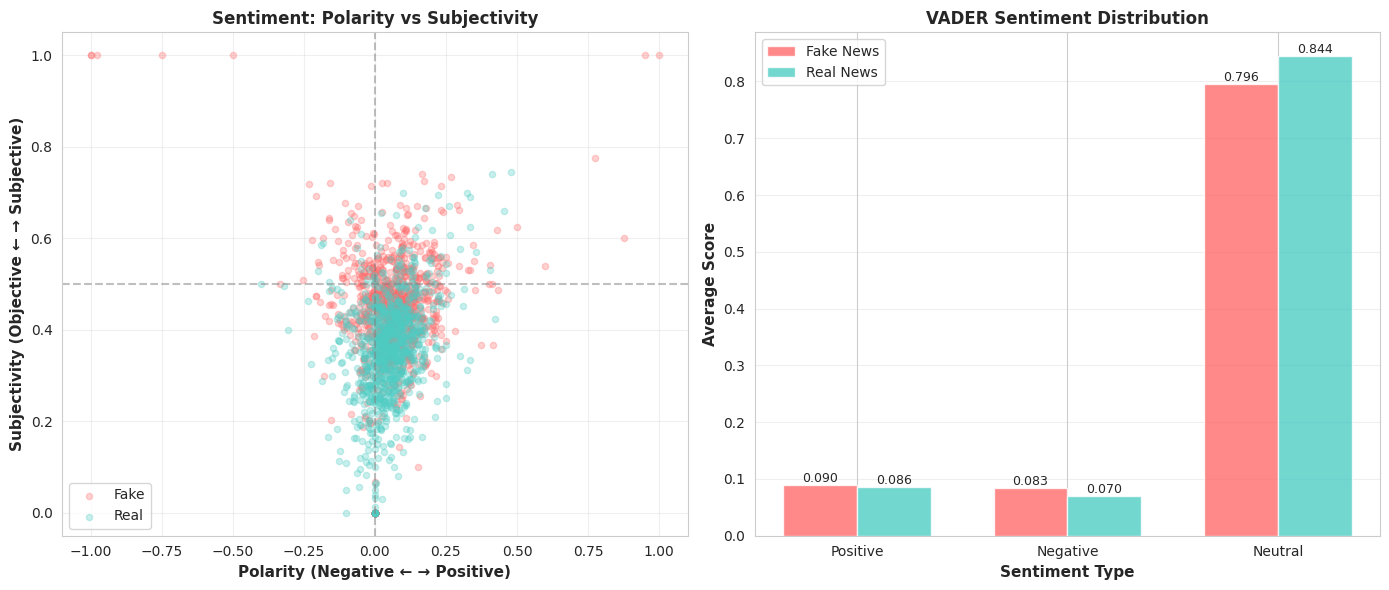

✅ Saved: 5_sentiment_analysis.png


In [ ]:
# ============================================================================
# CELL 25: VISUALIZATION 5 - SENTIMENT ANALYSIS
# ============================================================================
print("Creating sentiment analysis plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Subjectivity vs Polarity scatter
ax1 = axes[0]
fake_data = df_with_features[df_with_features['label']==0]
real_data = df_with_features[df_with_features['label']==1]

fake_sample = fake_data.sample(min(1000, len(fake_data)))
real_sample = real_data.sample(min(1000, len(real_data)))

ax1.scatter(fake_sample['polarity'], fake_sample['subjectivity'],
           alpha=0.3, label='Fake', color='#FF6B6B', s=20)
ax1.scatter(real_sample['polarity'], real_sample['subjectivity'],
           alpha=0.3, label='Real', color='#4ECDC4', s=20)

ax1.set_xlabel('Polarity (Negative ← → Positive)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Subjectivity (Objective ← → Subjective)', fontsize=11, fontweight='bold')
ax1.set_title('Sentiment: Polarity vs Subjectivity', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Plot 2: VADER sentiment bar chart
ax2 = axes[1]

vader_features = ['vader_positive', 'vader_negative', 'vader_neutral']
fake_vader = [df_with_features[df_with_features['label']==0][f].mean() for f in vader_features]
real_vader = [df_with_features[df_with_features['label']==1][f].mean() for f in vader_features]

x = np.arange(len(vader_features))
width = 0.35

bars1 = ax2.bar(x - width/2, fake_vader, width, label='Fake News', color='#FF6B6B', alpha=0.8)
bars2 = ax2.bar(x + width/2, real_vader, width, label='Real News', color='#4ECDC4', alpha=0.8)

ax2.set_xlabel('Sentiment Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Score', fontsize=11, fontweight='bold')
ax2.set_title('VADER Sentiment Distribution', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('5_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 5_sentiment_analysis.png")

🔴 CELL 26: Visualization 6 - Confusion Matrix


Creating confusion matrix heatmap...


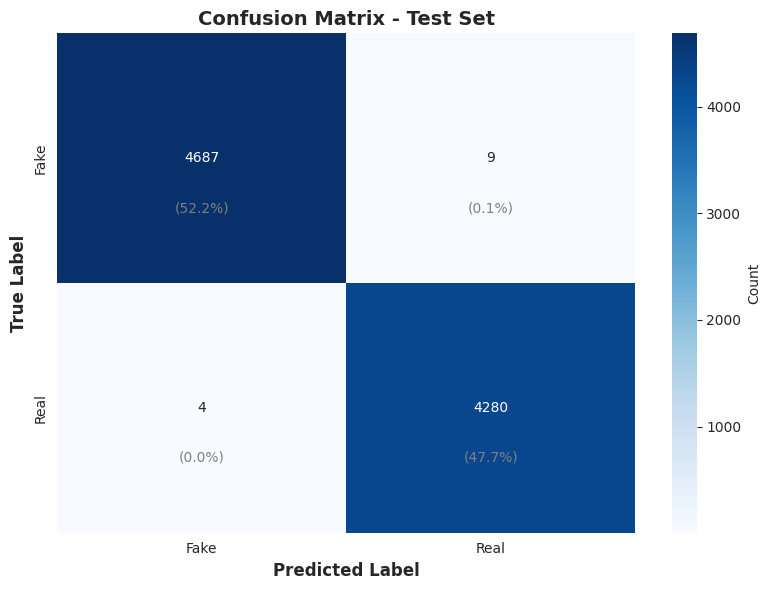

✅ Saved: 6_confusion_matrix.png


In [ ]:
# ============================================================================
# CELL 26: VISUALIZATION 6 - CONFUSION MATRIX HEATMAP
# ============================================================================
print("Creating confusion matrix heatmap...")

cm = confusion_matrix(test_labels, pred_labels)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
               ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('6_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 6_confusion_matrix.png")

🟢 CELL 27: Generate Summary Report


In [ ]:
# ============================================================================
# CELL 27: GENERATE SUMMARY REPORT
# ============================================================================
print("="*70)
print("GENERATING SUMMARY REPORT")
print("="*70)

summary_data = {
    'Feature Category': [
        'Length Features',
        'Caps & Punctuation',
        'Readability',
        'Sentiment',
        'Vocabulary',
        'Emotional Indicators'
    ],
    'Example Features': [
        'word_count, char_count, sentence_count',
        'caps_ratio, punctuation_ratio, exclamation_ratio',
        'flesch_reading_ease, gunning_fog, smog_index',
        'polarity, subjectivity, vader_compound',
        'vocabulary_richness (TTR)',
        'special_char_ratio, question_ratio'
    ],
    'Why Important': [
        'Fake news often shorter/longer than genuine articles',
        'Excessive caps indicate emotional manipulation',
        'Fake news written at lower reading levels',
        'Fake news more subjective and emotionally charged',
        'Fake news repeats keywords (lower diversity)',
        'Excessive punctuation shows emotional appeal'
    ],
    'Typical Pattern': [
        'Fake: Variable | Real: Consistent',
        'Fake: Higher | Real: Lower',
        'Fake: Lower scores | Real: Higher scores',
        'Fake: High subjectivity | Real: Low subjectivity',
        'Fake: Lower TTR | Real: Higher TTR',
        'Fake: Higher ratios | Real: Lower ratios'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n📊 FEATURE SUMMARY TABLE:")
print(summary_df.to_string(index=False))

summary_df.to_csv('feature_summary_table.csv', index=False)
print("\n✅ Saved: feature_summary_table.csv")

GENERATING SUMMARY REPORT

📊 FEATURE SUMMARY TABLE:
    Feature Category                                 Example Features                                        Why Important                                  Typical Pattern
     Length Features           word_count, char_count, sentence_count Fake news often shorter/longer than genuine articles                Fake: Variable | Real: Consistent
  Caps & Punctuation caps_ratio, punctuation_ratio, exclamation_ratio       Excessive caps indicate emotional manipulation                       Fake: Higher | Real: Lower
         Readability     flesch_reading_ease, gunning_fog, smog_index            Fake news written at lower reading levels         Fake: Lower scores | Real: Higher scores
           Sentiment           polarity, subjectivity, vader_compound    Fake news more subjective and emotionally charged Fake: High subjectivity | Real: Low subjectivity
          Vocabulary                        vocabulary_richness (TTR)         Fake news 

🔵 CELL 28: Final Summary and File List


In [ ]:
# ============================================================================
# CELL 28: FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("✅ ✅ ✅ COMPLETE PIPELINE FINISHED! ✅ ✅ ✅")
print("="*70)

print("\n📊 MODEL PERFORMANCE:")
print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n📁 FILES GENERATED:")
print("\n   Model Files:")
print("   1. hybrid_bert_fake_news_model/ (directory)")
print("   2. feature_scaler.pkl")
print("   3. pre_extractor.pkl")
print("   4. post_extractor.pkl")
print("   5. preprocessor.pkl")

print("\n   Visualization Files (For PPT/Report):")
print("   6. 1_class_distribution.png")
print("   7. 2_feature_comparison_boxplot.png")
print("   8. 3_feature_importance.png")
print("   9. 4_readability_comparison.png")
print("   10. 5_sentiment_analysis.png")
print("   11. 6_confusion_matrix.png")

print("\n   Data Files:")
print("   12. feature_importance.csv")
print("   13. feature_summary_table.csv")

print("\n📈 KEY FINDINGS:")
print(f"   • Fake news has {fake_words:.0f} words on average vs {real_words:.0f} for real news")
print(f"   • Fake news is {((fake_subj/real_subj - 1)*100):.1f}% more subjective")
print(f"   • Fake news has {fake_flesch:.1f} readability vs {real_flesch:.1f} for real news")
print(f"   • Top discriminative feature: {feature_importance.iloc[0]['Feature']}")

print("\n💾 TO DOWNLOAD FILES:")
print("   • Click folder icon on left")
print("   • Right-click files → Download")
print("   • Or use: from google.colab import files; files.download('filename')")

print("\n🎯 NEXT STEPS:")
print("   1. Download all PNG files for your PPT")
print("   2. Use CSV files for tables in report")
print("   3. Download model files if you want to use for inference")
print("   4. Cite statistics from Cell 19 in your report")

print("\n" + "="*70)
print("🎉 PROJECT COMPLETE! Good luck with your presentation! 🎉")
print("="*70)


✅ ✅ ✅ COMPLETE PIPELINE FINISHED! ✅ ✅ ✅

📊 MODEL PERFORMANCE:
   Test Accuracy: 0.9986 (99.86%)

📁 FILES GENERATED:

   Model Files:
   1. hybrid_bert_fake_news_model/ (directory)
   2. feature_scaler.pkl
   3. pre_extractor.pkl
   4. post_extractor.pkl
   5. preprocessor.pkl

   Visualization Files (For PPT/Report):
   6. 1_class_distribution.png
   7. 2_feature_comparison_boxplot.png
   8. 3_feature_importance.png
   9. 4_readability_comparison.png
   10. 5_sentiment_analysis.png
   11. 6_confusion_matrix.png

   Data Files:
   12. feature_importance.csv
   13. feature_summary_table.csv

📈 KEY FINDINGS:
   • Fake news has 465 words on average vs 431 for real news
   • Fake news is 19.2% more subjective
   • Fake news has 50.8 readability vs 43.1 for real news
   • Top discriminative feature: gunning_fog

💾 TO DOWNLOAD FILES:
   • Click folder icon on left
   • Right-click files → Download
   • Or use: from google.colab import files; files.download('filename')

🎯 NEXT STEPS:
   1. Do

📝 Optional: CELL 29 - Download All Files


In [ ]:
# ============================================================================
# CELL 29 (OPTIONAL): DOWNLOAD ALL FILES AT ONCE
# ============================================================================
print("Preparing files for download...")

from google.colab import files
import zipfile
import os

# Create zip file
zip_filename = 'fake_news_detection_outputs.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add visualization files
    for i in range(1, 7):
        if i == 1:
            filename = f'{i}_class_distribution.png'
        elif i == 2:
            filename = f'{i}_feature_comparison_boxplot.png'
        elif i == 3:
            filename = f'{i}_feature_importance.png'
        elif i == 4:
            filename = f'{i}_readability_comparison.png'
        elif i == 5:
            filename = f'{i}_sentiment_analysis.png'
        elif i == 6:
            filename = f'{i}_confusion_matrix.png'

        if os.path.exists(filename):
            zipf.write(filename)
            print(f"✓ Added: {filename}")

    # Add CSV files
    for csv_file in ['feature_importance.csv', 'feature_summary_table.csv']:
        if os.path.exists(csv_file):
            zipf.write(csv_file)
            print(f"✓ Added: {csv_file}")

print(f"\n✅ Created: {zip_filename}")
print("Downloading...")
files.download(zip_filename)
print("✅ Download complete!")

Preparing files for download...
✓ Added: 1_class_distribution.png
✓ Added: 2_feature_comparison_boxplot.png
✓ Added: 3_feature_importance.png
✓ Added: 4_readability_comparison.png
✓ Added: 5_sentiment_analysis.png
✓ Added: 6_confusion_matrix.png
✓ Added: feature_importance.csv
✓ Added: feature_summary_table.csv

✅ Created: fake_news_detection_outputs.zip
Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete!


In [ ]:
# ============================================================================
# TEST CASES FOR MODEL EVALUATION
# ============================================================================

test_cases = {
    "REAL": [
        "The Reserve Bank of India kept the repo rate unchanged at 6.5 percent on Friday, citing persistent inflationary pressures and global economic uncertainty.",

        "Microsoft announced new AI-powered features for Windows, focusing on productivity and security improvements. The updates will roll out gradually worldwide.",

        "According to the World Health Organization, regular physical activity reduces the risk of heart disease and diabetes.",

        "WASHINGTON (Reuters) - The Federal Reserve on Wednesday kept interest rates unchanged, citing moderating inflation and steady economic growth. Policymakers said future rate decisions would depend on incoming data."
    ],

    "FAKE": [
        "BREAKING!!! Government SECRETLY decided to ban all private bank accounts from next month!!! Citizens are in SHOCK!!!",

        "Doctors HATE this trick! Drinking salt water every morning cures cancer and diabetes in just 7 days!",

        "NASA insiders confirm the moon landing was FAKE and filmed in a secret underground studio.",

        "Elon Musk announces FREE Bitcoin giveaway for everyone who registers today. Hurry before it disappears!"
    ],

    "BORDERLINE": [
        "A viral video claims that 5G networks cause health problems, though experts say there is no scientific evidence.",

        "Social media posts allege a new law will tax savings heavily, but no official government notification exists."
    ]
}

# ============================================================================
# RUN TESTS
# ============================================================================

print("="*80)
print("RUNNING TEST CASES")
print("="*80)

for category, texts in test_cases.items():
    print(f"\n🔹 CATEGORY: {category}")
    print("-"*80)

    for idx, text in enumerate(texts, 1):
        result = predict_news(
            text,
            model,
            tokenizer,
            scaler,
            pre_extractor,
            post_extractor,
            preprocessor
        )

        print(f"\nTest {idx}:")
        print(f"Text: {text}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']}")
        print(f"Probabilities -> Fake: {result['probabilities']['Fake']}, Real: {result['probabilities']['Real']}")
        print("-"*80)

print("\n✅ TESTING COMPLETE")


RUNNING TEST CASES

🔹 CATEGORY: REAL
--------------------------------------------------------------------------------

Test 1:
Text: The Reserve Bank of India kept the repo rate unchanged at 6.5 percent on Friday, citing persistent inflationary pressures and global economic uncertainty.
Prediction: Real
Confidence: 0.9999
Probabilities -> Fake: 0.0001, Real: 0.9999
--------------------------------------------------------------------------------

Test 2:
Text: Microsoft announced new AI-powered features for Windows, focusing on productivity and security improvements. The updates will roll out gradually worldwide.
Prediction: Real
Confidence: 0.6023
Probabilities -> Fake: 0.3977, Real: 0.6023
--------------------------------------------------------------------------------

Test 3:
Text: According to the World Health Organization, regular physical activity reduces the risk of heart disease and diabetes.
Prediction: Fake
Confidence: 0.9439
Probabilities -> Fake: 0.9439, Real: 0.0561
------